# Importa bibliotecas

Obs: 
- Projeto realizado em um Macbook Air M1 no VS Code
- Foi utilizado o GitHub Copilot para desenvolver os scripts deste notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report

# Carraga DataFrames

In [2]:
sa = pd.read_csv('arquivo_sem_ataque.csv')
ca = pd.read_csv('arquivo_com_ataque.csv')

/var/folders/hn/qvlm7lld3lj_m0hzq_wcpvxc0000gn/T/ipykernel_52484/1137074802.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  sa = pd.read_csv('arquivo_sem_ataque.csv')


# 1) EDA

Realizar uma análise exploratória dos dados, levantando estatísticas e identificando
suas características, com a finalidade de apontar quais atributos são relevantes para
a análise.

In [3]:
# Verificar amostra dos dados
 
sa.sample(1).T

,350328
hora,2024-05-16 01:05:17 UTC
ip,200.173.5acb9d2aa23999593ec3dacfaba880b7765e03...
metodo,POST
protocolo,HTTP/2.0
hostname,7fce4671bd47ea8e29136374311f0f3cf48aa0021e1352...
uri,/28f877315a908cd3b81e2511f067ff1bda81a57b1e7c1...
querystring,?c73b17abefd68577a26bc88b02346fd4def10e878c153...
status_code,400
f0_,NaN
useragent,okhttp/3.14.9


In [4]:
ca.sample(1).T

,214853
hora,2024-05-15 14:10:43 UTC
ip,177.130.be1292a060fde595c0defa0da6922ff160de9c...
metodo,GET
protocolo,HTTP/2.0
hostname,ea6663ced094e2ef448b4575783e8d1afa86be30ea9acf...
uri,/1d0173178a98ef906d7577affe7d6175e3a23b08be521...
querystring,NaN
status_code,200
f0_,https://5a105da9abd0df1b4a353fbecf6b5c6478499c...
useragent,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


## status_code:
Analisando a distribuição do dados, vemos que durante o ataque, pode have uma diferença nos status codes do servidor. No período sem ataque há uma distribução mais diversa de status_code, enquanto que durante o ataque há mais (200, 502)

## tamanho_request:
- Durante o período sem ataque o tamanho médio das requisições é de 5528 bytes
- Durante o período com ataque é de 1048 bytes. A diferença no tamanho indica que durante o ataque os pacotes são menores
- Os valores dos pacotes nos percentis são maiores para o período sem ataque em comparação com o periodo com ataque. Isso afirma a premissa anterior, de que durante os ataques os pacotes são menores
## tamanho_resposta
- Durante o ataque o tamanho da resposta é maior do que fora do ataque. Isso indica que o atacante quer forçar uma resposta maior do servidor.

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print('SA: ', sa.describe(percentiles=[0.9, 0.95, 0.99]))
print('\n=====================================================\n')
print('CA: ', ca.describe(percentiles=[0.9, 0.95, 0.99]))

SA:         status_code  tamanho_request  tamanho_resposta
count   917527.000       917527.000        653185.000
mean       226.643         5528.957         50327.614
std         68.458        91381.164        239333.979
min        101.000            7.000             0.000
50%        200.000          161.000          4084.000
90%        400.000        28372.000         87134.000
95%        400.000        40460.700        146910.000
99%        400.000        53403.000        736221.000
max        503.000     79523876.000      87036285.000


CA:         status_code  tamanho_request  tamanho_resposta
count   348864.000       348864.000        256033.000
mean       213.451         1048.826         54534.352
std         57.608        11088.763        140591.237
min        200.000           10.000             0.000
50%        200.000           77.000         11390.000
90%        200.000         1748.000        136642.000
95%        302.000         2397.000        248418.000
99%        499.0

Analisando mais profundamente o tamanho_request: Vamos definir um cut off de 90% no percentil dos dados, para excluir outliers e poder visualizar melhor a distribuição do tamanho de requests. 

In [6]:
cutof = .9
tamanho_request_sa = sa[sa['tamanho_request']<sa['tamanho_request'].quantile(cutof)]['tamanho_request']
tamanho_request_ca = ca[ca['tamanho_request']<ca['tamanho_request'].quantile(cutof)]['tamanho_request']

Com isso, vemos que durante o ataque o tamanho da cauda do "Sem Ataque" é maior que "Com ataque". Indicando que na ausência do ataque há uma variedade nas requisições feitas, enquanto que durante o ataque as requisições feitas são praticamente do mesmo tipo.


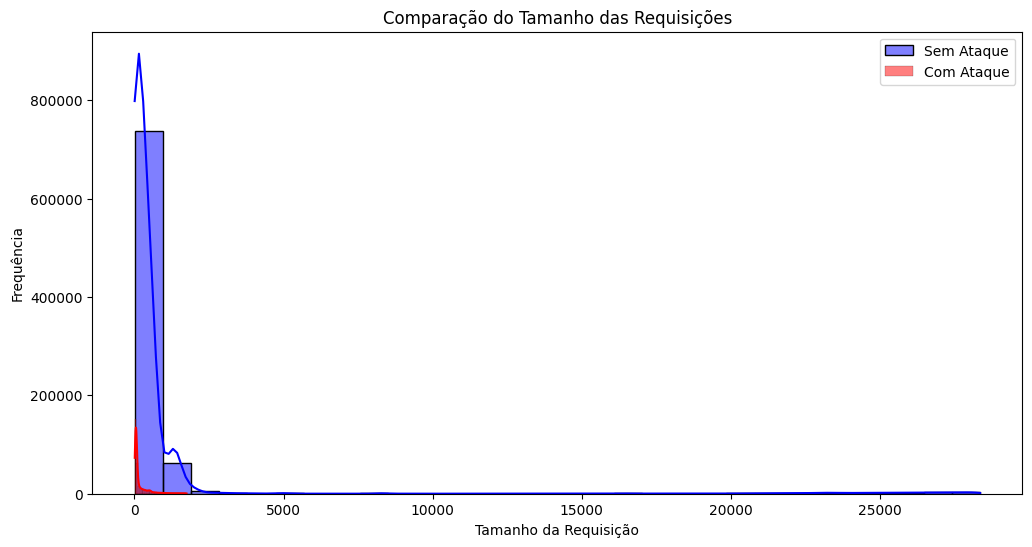

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(tamanho_request_sa, color="blue", label='Sem Ataque', kde=True, bins=30)
sns.histplot(tamanho_request_ca, color="red", label='Com Ataque', kde=True, bins=30)
plt.title('Comparação do Tamanho das Requisições')
plt.xlabel('Tamanho da Requisição')
plt.ylabel('Frequência')
plt.legend()
plt.show()

## status_code

Analisando o status de códigos na ausência de ataque vemos um predominância de código 200 e alguns 404 que indica o comportanmento normal de uma aplicação. Durante o ataque de DDOs vemos que o código 200 aparece bem mais, enquanto não há nenhum código 404, indicando uma tentativa de sobrecarga.

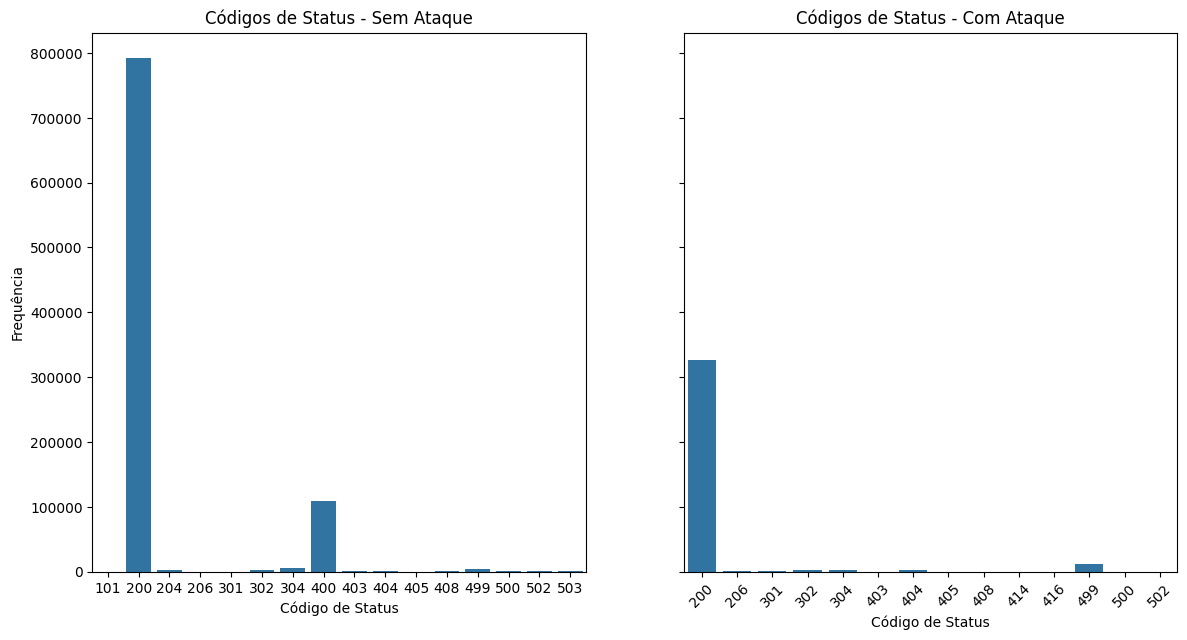

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
sns.countplot(ax=axes[0], x='status_code', data=sa)
axes[0].set_title('Códigos de Status - Sem Ataque')
axes[0].set_xlabel('Código de Status')
axes[0].set_ylabel('Frequência')

sns.countplot(ax=axes[1], x='status_code', data=ca)
axes[1].set_title('Códigos de Status - Com Ataque')
axes[1].set_xlabel('Código de Status')
axes[1].set_ylabel('Frequência')
plt.xticks(rotation=45)
plt.show()


# Tamanho da requisição ao longo do tempo

Vemos que durante o ataque o tamanho das requisições são bem menores do que durante o período sem ataque.

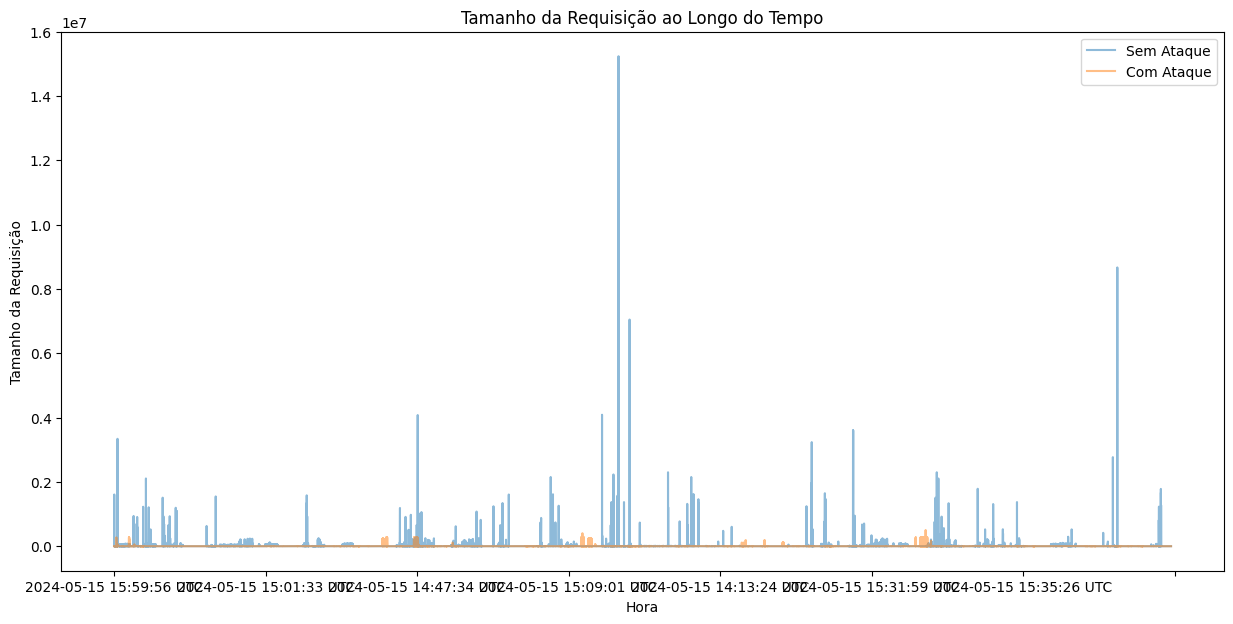

In [9]:
plt.figure(figsize=(15, 7))
sa.head(len(ca)).set_index('hora')['tamanho_request'].plot(label='Sem Ataque', alpha=0.5)
ca.set_index('hora')['tamanho_request'].plot(label='Com Ataque', alpha=0.5)
plt.title('Tamanho da Requisição ao Longo do Tempo')
plt.xlabel('Hora')
plt.ylabel('Tamanho da Requisição')
plt.legend()
plt.show()


## Volume de requisições ao longo do tempo

Aqui vemos claramente que durante o ataque o volume de requisições cresce ordens de grandeza mais do que quando não há o ataque. Além do grande volume, as distribuição durante o ataque e sem o ataque é bem distinta.

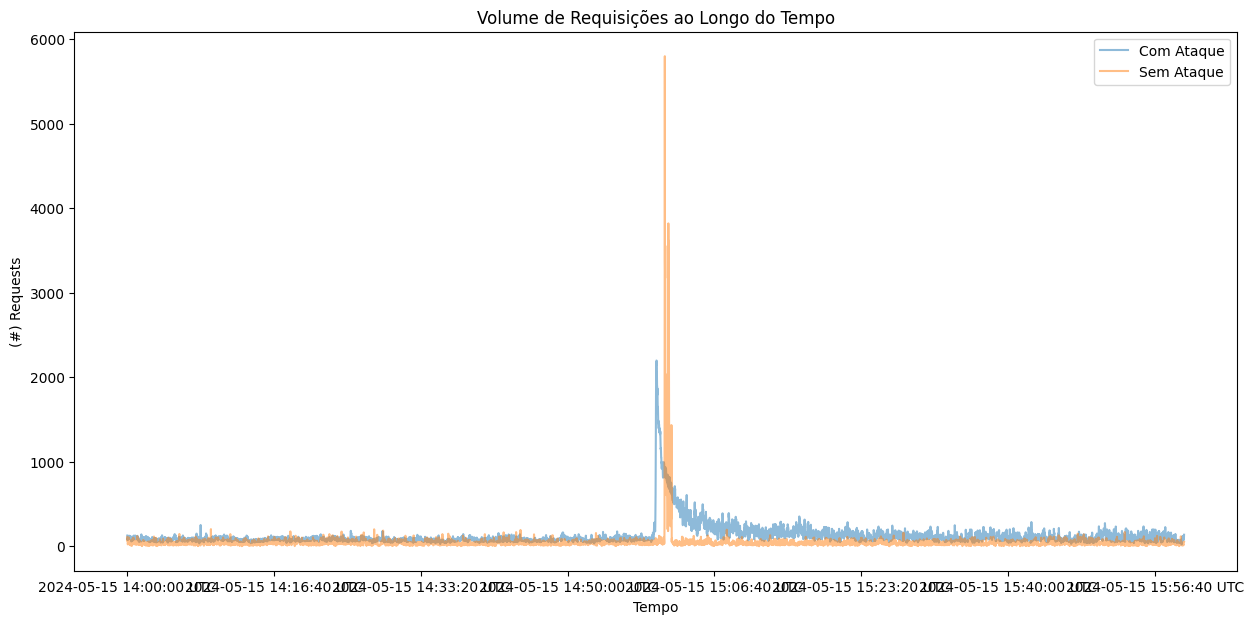

In [10]:
volume_sa = sa.groupby('hora').size()
volume_ca = ca.groupby('hora').size()

volume_sa = volume_sa.sort_index()
volume_ca = volume_ca.sort_index()


plt.figure(figsize=(15, 7))
volume_sa.plot(label='Com Ataque', alpha=0.5)
volume_ca.plot(label='Sem Ataque', alpha=0.5)
plt.title('Volume de Requisições ao Longo do Tempo')
plt.xlabel('Tempo')
plt.ylabel('(#) Requests')
plt.legend()
plt.show()

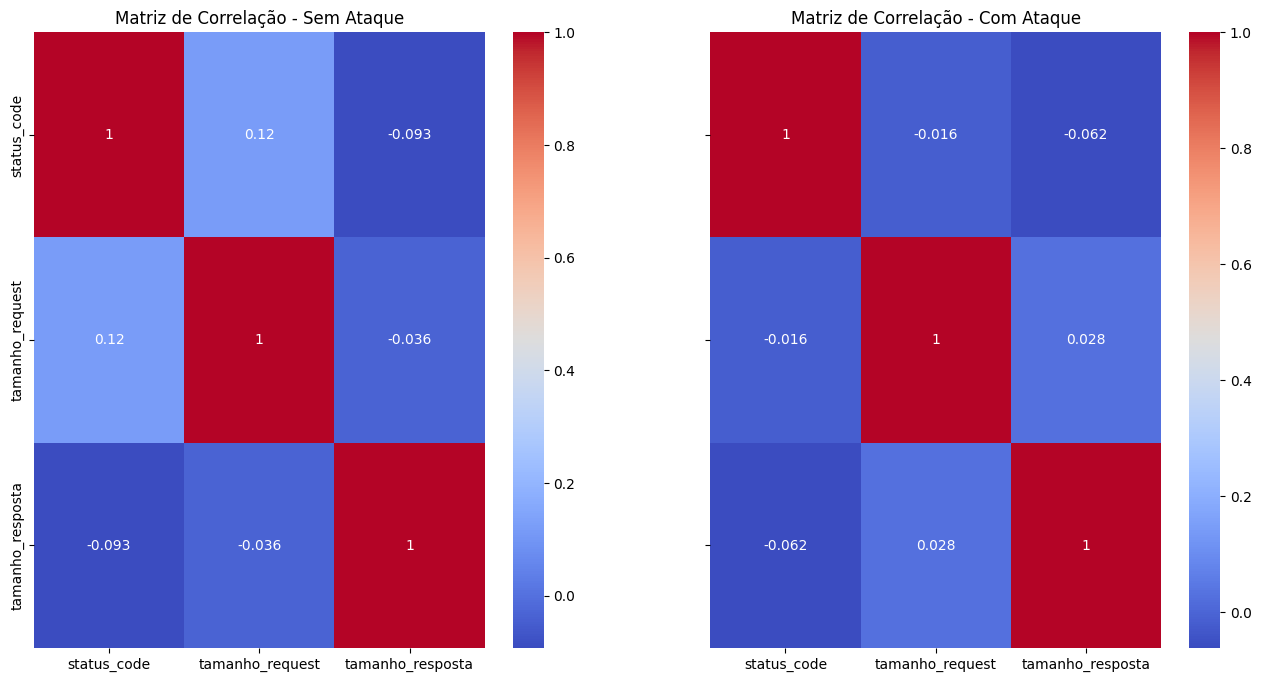

In [11]:
sa_numeric = sa.select_dtypes(include=[np.number])
ca_numeric = ca.select_dtypes(include=[np.number])

correlation_matrix_sem_ataque = sa_numeric.corr()
correlation_matrix_com_ataque = ca_numeric.corr()

fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
sns.heatmap(correlation_matrix_sem_ataque, annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Matriz de Correlação - Sem Ataque')

sns.heatmap(correlation_matrix_com_ataque, annot=True, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Matriz de Correlação - Com Ataque')
plt.show()

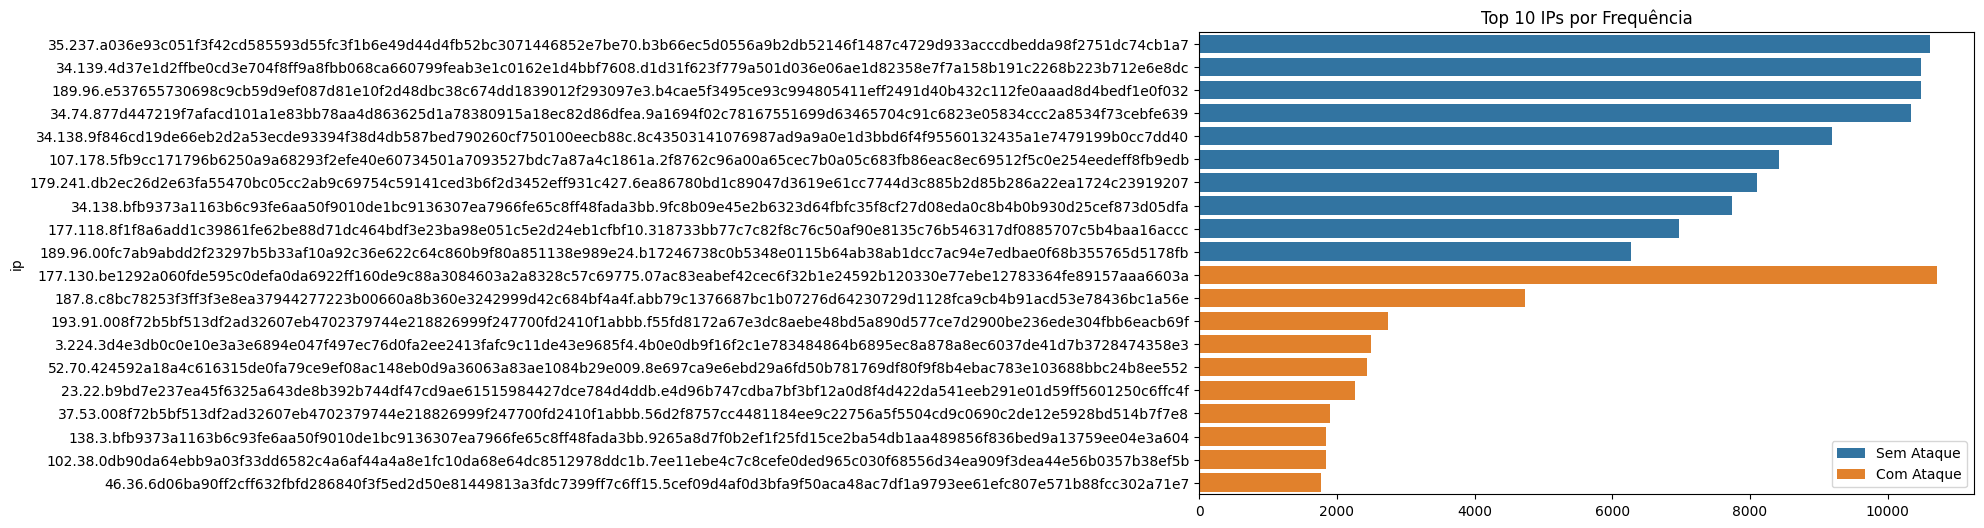

In [12]:
# Contar frequências
ip_counts = sa['ip'].value_counts().head(10)
method_counts = sa['metodo'].value_counts()

ip_counts_ca = ca['ip'].value_counts().head(10)
method_counts_ca = ca['metodo'].value_counts()

# Plotar as frequências
plt.figure(figsize=(10, 6))
sns.barplot(x=ip_counts.values, y=ip_counts.index, label='Sem Ataque')
sns.barplot(x=ip_counts_ca.values, y=ip_counts_ca.index, label='Com Ataque')
plt.title('Top 10 IPs por Frequência')
plt.show()

Durante o ataque o método mais utilizado é o GET, enquanto que sem o ataque o método mais utilizado é o POST.

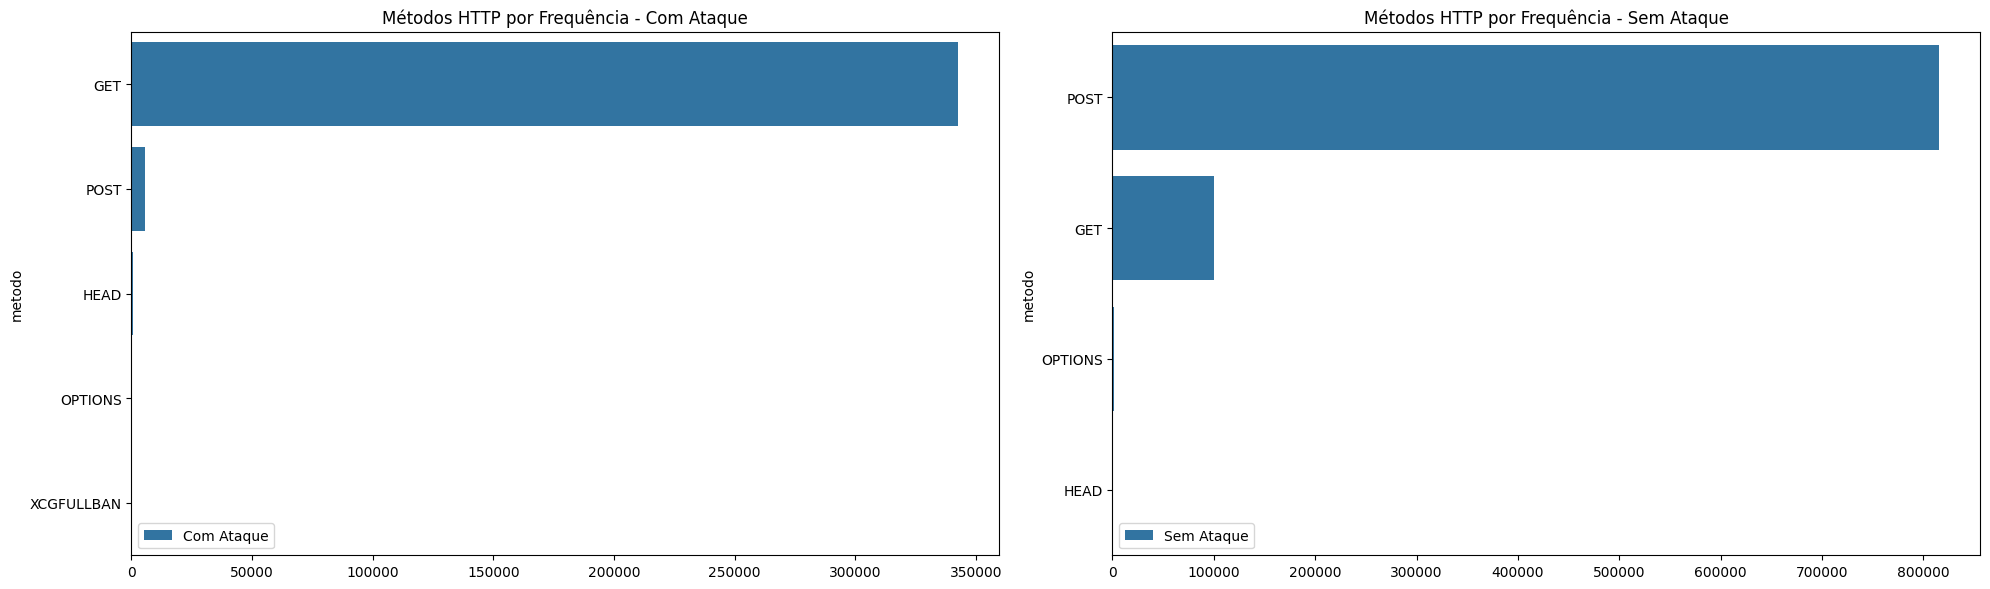

In [13]:
plt.figure(figsize=(20, 6))  

plt.subplot(1, 2, 1)  
sns.barplot(x=method_counts_ca.values, y=method_counts_ca.index, label='Com Ataque')
plt.title('Métodos HTTP por Frequência - Com Ataque', )


plt.subplot(1, 2, 2) 
sns.barplot(x=method_counts.values, y=method_counts.index, label='Sem Ataque')
plt.title('Métodos HTTP por Frequência - Sem Ataque')

plt.tight_layout() 
plt.show()

Durante o ataque há mais querystring não nulas do que sem o ataque. A f0_ é predominantemente nula durante o ataque, enquanto que sem o ataque ela é 90% das vezes preenchida.

In [14]:
print('Com Ataque:')
print("Percentual de nulos em 'querystring':", round(sa['querystring'].isnull().mean(),5) * 100, "%")
print("Percentual de nulos em 'f0_':", round(sa['f0_'].isnull().mean(),5) * 100, "%")
print('='*60)
print('Sem ataque')
print("Percentual de nulos em 'querystring':", round(ca['querystring'].isnull().mean(),5) * 100, "%")
print("Percentual de nulos em 'f0_':", round(ca['f0_'].isnull().mean(),5) * 100, "%")


Com Ataque:
Percentual de nulos em 'querystring': 40.386 %
Percentual de nulos em 'f0_': 83.956 %
Sem ataque
Percentual de nulos em 'querystring': 76.142 %
Percentual de nulos em 'f0_': 10.241 %


Vemos que durante o ataque são realizadas requisições de localizades incomuns, como DE, LY, RU, NL, PT.

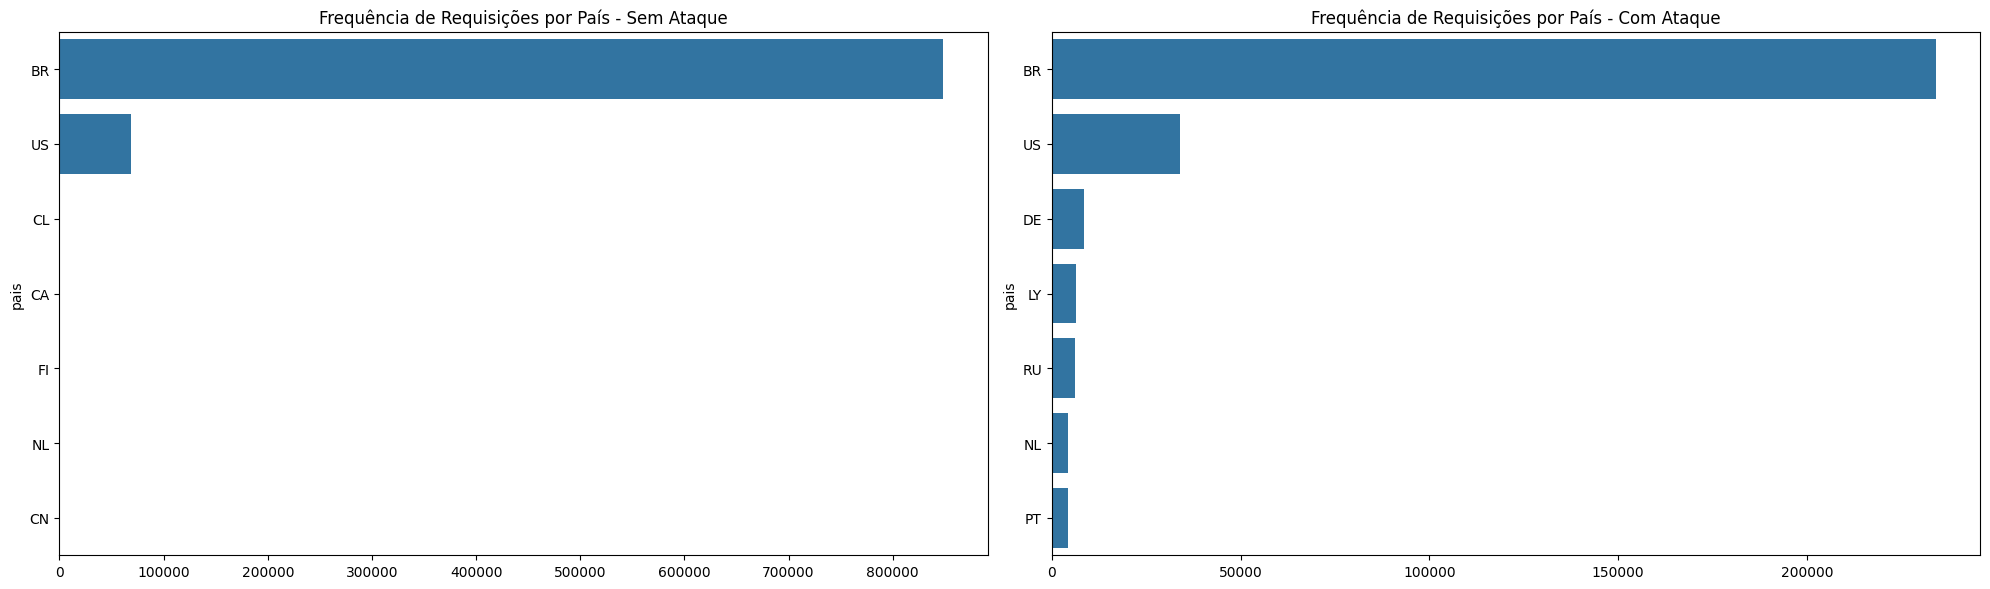

In [15]:
country_counts_sa = sa['pais'].value_counts().head(7)
country_counts_ca = ca['pais'].value_counts().head(7)


plt.figure(figsize=(20, 6)) 
plt.subplot(1, 2, 1) 
sns.barplot(x=country_counts_sa.values, y=country_counts_sa.index)
plt.title('Frequência de Requisições por País - Sem Ataque')


plt.subplot(1, 2, 2)  
sns.barplot(x=country_counts_ca.values, y=country_counts_ca.index)
plt.title('Frequência de Requisições por País - Com Ataque')

plt.tight_layout()  
plt.show()

Dada a premissa que os ataques são feitos em regiões não usuais, fora do Brasil, e também os padrões nos tamanhos de request, resposta e métodos. É possível que os ataques sigam um padrão. Com base nisso, vamos utiliza entropia para medir a aleatoridade das variáveis. Um ataque que segue um padrão, vai apresentar um baixo valor de entropia, pela falta de aleatoridade.

In [16]:
# Função para calcular a entropia de uma string
def calculate_entropy(string):
    probabilities = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
    entropy = - sum(p * np.log2(p) for p in probabilities)
    return entropy


Analisando a distribuição de useragent, vemos claramente que durante o ataque a entropia segue um padrão, enquanto que sem o ataque ela segue outra.

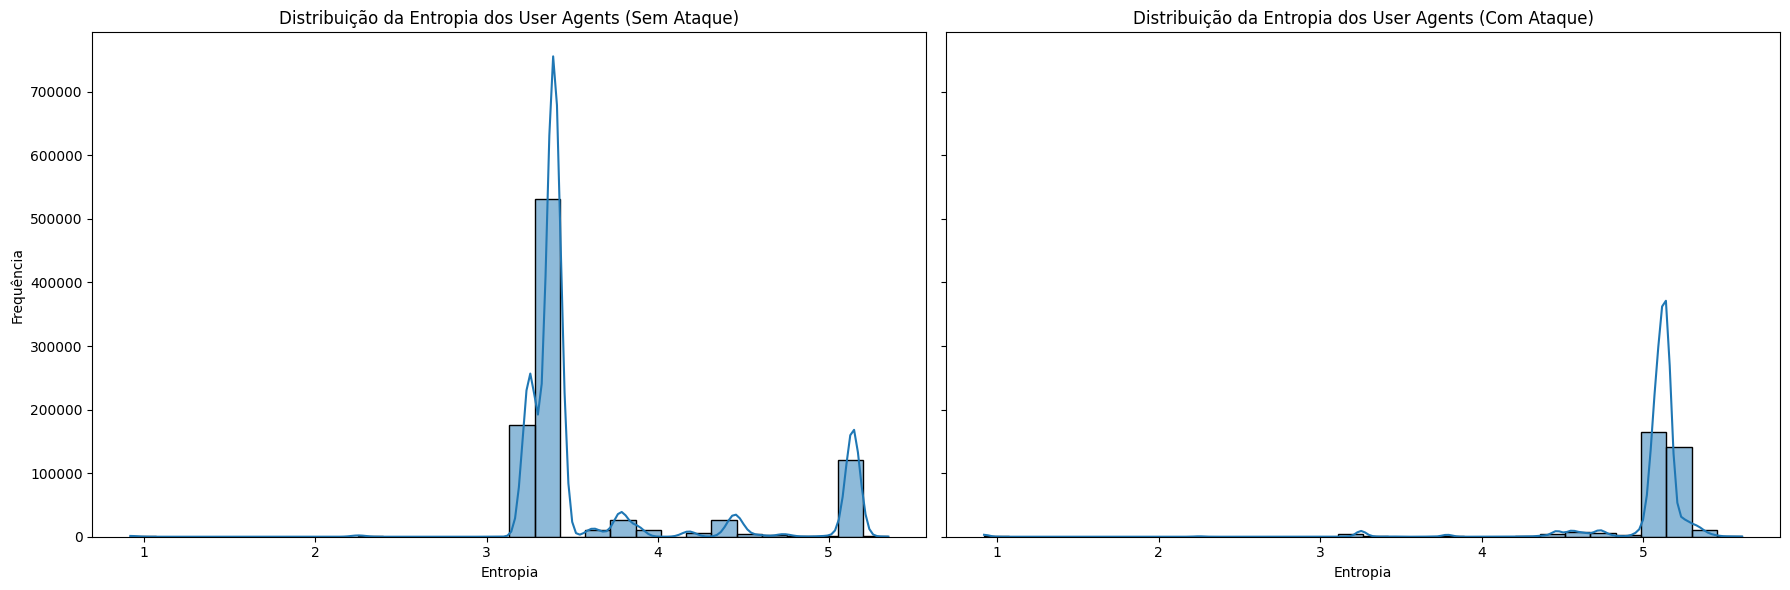

In [17]:
sa['useragent_entropy'] = sa['useragent'].astype(str).apply(calculate_entropy)
ca['useragent_entropy'] = ca['useragent'].astype(str).apply(calculate_entropy)


fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.histplot(sa['useragent_entropy'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribuição da Entropia dos User Agents (Sem Ataque)')
axs[0].set_xlabel('Entropia')
axs[0].set_ylabel('Frequência')

sns.histplot(ca['useragent_entropy'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribuição da Entropia dos User Agents (Com Ataque)')
axs[1].set_xlabel('Entropia')
axs[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

Analisando a distribuição da entropia para a querystring vemos que sem o ataque a aleatoridade é maior e durante o ataque ela é menor. 

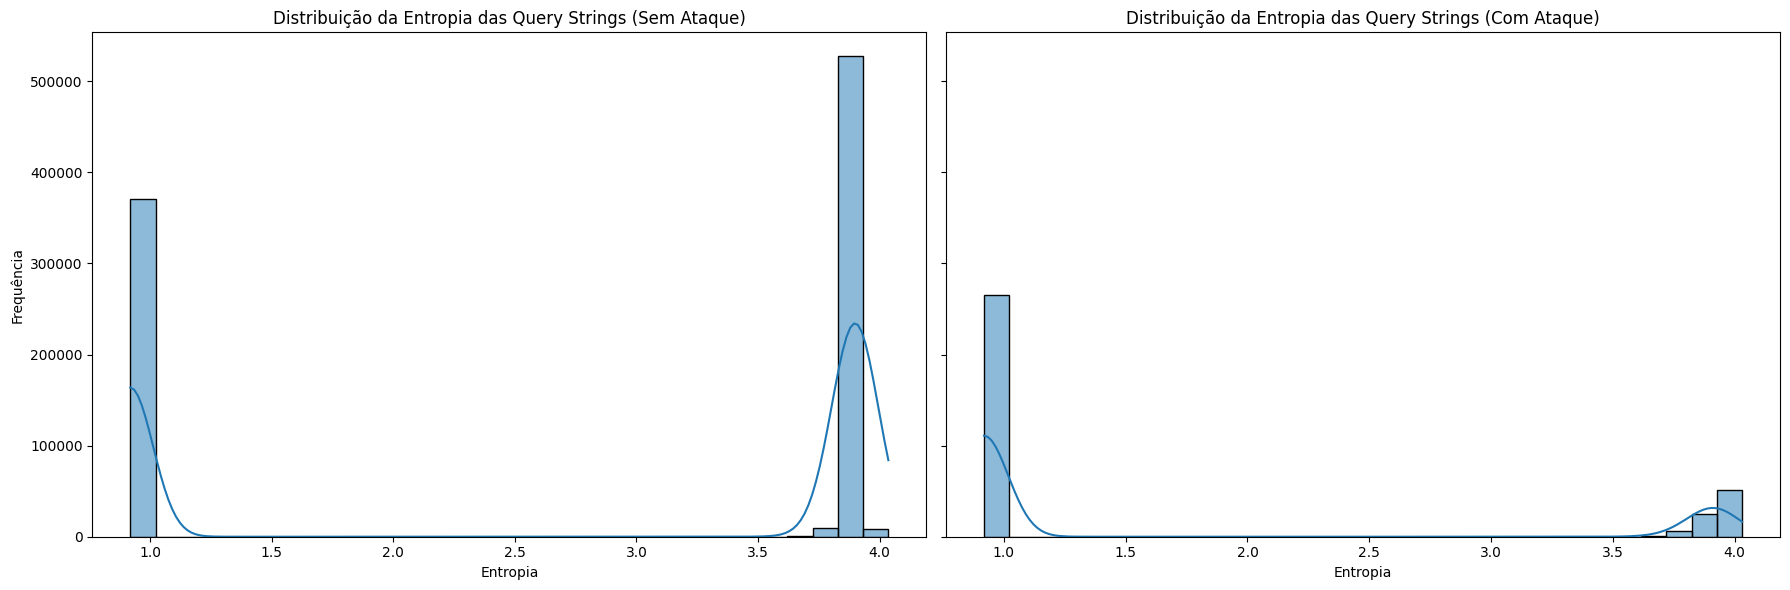

In [18]:
sa['querystring_entropy'] = sa['querystring'].astype(str).apply(calculate_entropy)
ca['querystring_entropy'] = ca['querystring'].astype(str).apply(calculate_entropy)
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.histplot(sa['querystring_entropy'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribuição da Entropia das Query Strings (Sem Ataque)')
axs[0].set_xlabel('Entropia')
axs[0].set_ylabel('Frequência')

sns.histplot(ca['querystring_entropy'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribuição da Entropia das Query Strings (Com Ataque)')
axs[1].set_xlabel('Entropia')
axs[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()


Como não temos muito tempo, vamos montar o nosso modelo com base em um threshold na variável de ´querystring_entropy´. Onde um ´querystring_entropy´ baixo, indica valores previsíveis, consequentemente um ataque. Olhando para os quantis abaixo, vamos estabelecer um valor de corte <0,95. Este será o nosso base-line.

In [19]:
print('Sem Ataque', sa['querystring_entropy'].describe())
print('='*60)
print('Com Atque', ca['querystring_entropy'].describe())

Sem Ataque count   917527.000
mean         2.694
std          1.462
min          0.918
25%          0.918
50%          3.905
75%          3.905
max          4.036
Name: querystring_entropy, dtype: float64
Com Atque count   348864.000
mean         1.630
std          1.272
min          0.918
25%          0.918
50%          0.918
75%          0.918
max          4.031
Name: querystring_entropy, dtype: float64


# Modelo de base line

2. O primeiro arquivo `arquivo_sem_ataque.csv` apresenta um período com tráfego
normal, enquanto que o `arquivo_com_ataque.csv` apresenta um período de tráfego
normal, seguido de um período com ataque e por fim retorno ao tráfego normal. A
partir da sua análise exploratória, explique porque podemos identificar um ataque no
segundo arquivo, ou seja, mostrar qual lógica usou para identificar o aumento de
tráfego.

Analisando o gráfico, é possível visualizar que a ´querystring_entropy´captura o ataque. Com base nesta variável vamos construir um modelo de classificação, pois ´querystring_entropy´ mostrou diferença significativa nos períodos de ataque e períodos normais. A entropia baixa durante os ataques indica padrões reptitivos, enquanto que a entropia alta durante o período de normalizadade indica a diversidade de um tráfico legítimo.

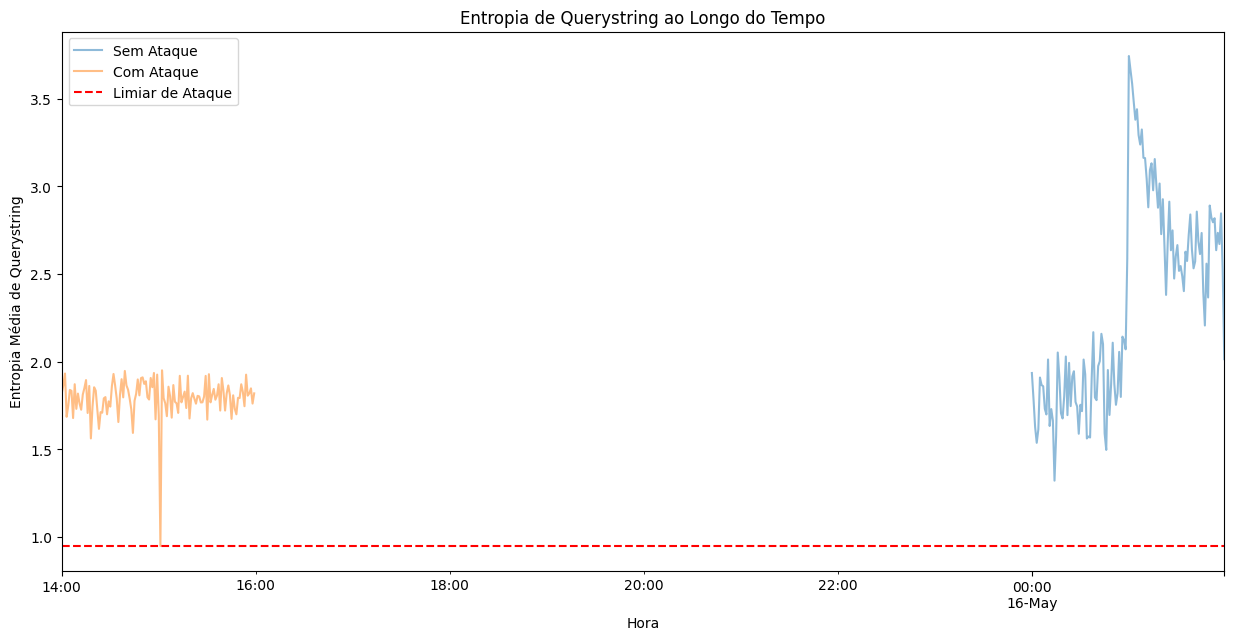

In [20]:
sa['hora'] = pd.to_datetime(sa['hora'])
ca['hora'] = pd.to_datetime(ca['hora'])

# Agrupar os dados por algum intervalo de tempo e calcular a média da entropia
entropia_sa = sa.groupby(pd.Grouper(key='hora', freq='1min'))['querystring_entropy'].mean()
entropia_ca = ca.groupby(pd.Grouper(key='hora', freq='1min'))['querystring_entropy'].mean()

sa['ataque'] = sa['querystring_entropy'] < .95
ca['ataque'] = ca['querystring_entropy'] < .95

# Plotar os resultados
plt.figure(figsize=(15, 7))
entropia_sa.plot(label='Sem Ataque', alpha=0.5)
entropia_ca.plot(label='Com Ataque', alpha=0.5)
plt.axhline(y=.95, color='r', linestyle='--', label='Limiar de Ataque')
plt.title('Entropia de Querystring ao Longo do Tempo')
plt.xlabel('Hora')
plt.ylabel('Entropia Média de Querystring')
plt.legend()
plt.show()

## Modelo

In [21]:
ca = pd.read_csv('arquivo_com_ataque.csv')

# Remover colunas com muitos valores nulos
ca.fillna(method='ffill', inplace=True)
ca.fillna(sa.mean(numeric_only=True), inplace=True)


# Codificar variáveis categóricas
label_encoders = {}
categorical_columns = ['ip', 'metodo', 'protocolo', 'hostname', 'uri', 'querystring', 'f0_', 'useragent', 'organizacao', 'pais', 'cidade', 'cookie_sessao', 'fingerprint1', 'fingerprint2', 'fingerprint3']
for column in categorical_columns:
    le = LabelEncoder()
    ca[column] = le.fit_transform(ca[column].astype(str))  # Garantir que todas as colunas sejam strings antes de codificar
    label_encoders[column] = le

# Convertando hora para timestamp
ca['hora'] = pd.to_datetime(ca['hora'])
ca['hora'] = ca['hora'].dt.tz_localize(None)
ca['timestamp'] = (ca['hora'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Calculando a entropia da querystring
ca['querystring_entropy'] = ca['querystring'].astype(str).apply(calculate_entropy)
ca['ataque'] = ca['querystring_entropy'] < .95

# Removendo colunas desnecessárias
X = ca.drop(['ataque', 'hora', 'querystring_entropy'], axis=1)  # substitui 'hora' com 'timestamp'
y = ca['ataque']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)


O resultado do modelo indica que:

- Há uma alta precisão para o modelo. 
- Poucos falsos-positivos e falsos-negativos
- Um alto F1 score indica que o modelo consegue diferenciar bem de um tráfego legitímo e um de ataque

In [22]:
# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliar o modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     69142
        True       0.98      0.52      0.68       631

    accuracy                           1.00     69773
   macro avg       0.99      0.76      0.84     69773
weighted avg       1.00      1.00      0.99     69773



In [23]:
print(accuracy_score(y_test, y_pred))


0.9955856850070944


A curva ROC mostra que o modelo é eficaz na distinção entre ataque e não ataques. Isso indica uma exelente capacidade preditiva.

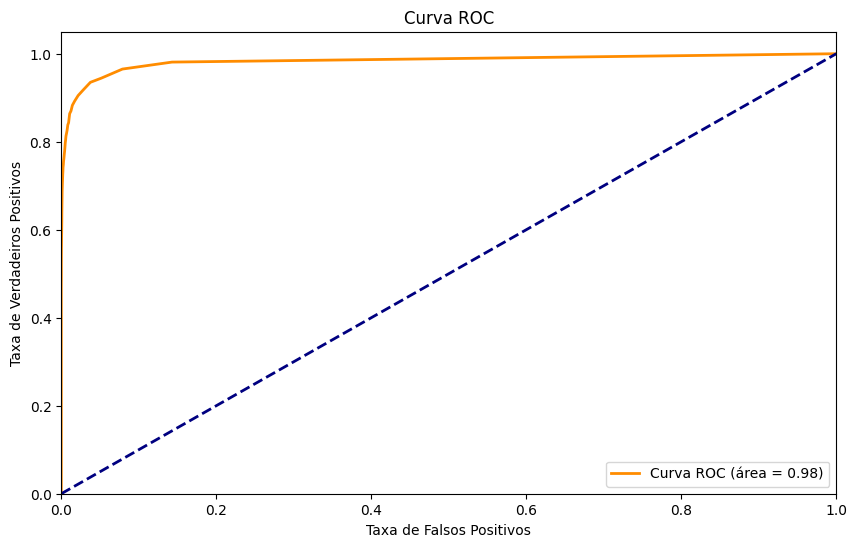

In [25]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()